In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)

In [21]:
from tensorflow import keras
from tensorflow.keras.layers import GRU, LSTM, Dense, Input, Masking, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from catboost import CatBoostClassifier


In [3]:
tackles = pd.read_csv("../data/tackles.csv")

In [4]:
features_data = pd.concat([pd.read_csv(f"../data/features_week_{i}.csv") for i in range(1,10)]).reset_index(drop=True)

In [164]:
visualization_tracking_data = pd.read_csv("../data/visualization_tracking_data.csv")
tackling_probability = pd.read_csv("../data/tackling_probability.csv")

features_data["direction_to_ball_carrier"]
modeling_data = visualization_tracking_data.merge(
    features_data[["gameId", "playId", "nflId", "frameId", "distance_to_ball_carrier", "ball_carrier_distance_to_endzone"]], 
    on=["gameId", "playId", "nflId", "frameId"]
)
modeling_data = modeling_data.merge(tackling_probability, on=["gameId", "playId", "nflId", "frameId"])

In [165]:
defense = modeling_data[(modeling_data["is_defense"]) & (~modeling_data["ball_carrier_id"].isna())].copy()

In [381]:
from scipy.signal import find_peaks

In [393]:
test_peaks = tackles[((tackles["tackle"]==1)|(tackles["assist"]==1))&(tackles["pff_missedTackle"]==1)]

In [398]:
def func(x):
    try:
        return find_peaks(defense.set_index(["gameId", "playId","nflId"]).loc[(x["gameId"], x["playId"],x["nflId"])]["tackling_probability"].values,  height=0.6, distance=10)
    except:
        return -1

res_peaks = test_peaks.apply(lambda x: func(x), axis=1)

C:\Users\mleca\AppData\Local\Temp\ipykernel_15524\1843744767.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  return len(find_peaks(defense.set_index(["gameId", "playId","nflId"]).loc[(x["gameId"], x["playId"],x["nflId"])]["tackling_probability"].values,  height=0.6, distance=10)[0])


In [ ]:
res_peaks

In [401]:
res_peaks.value_counts()

 2    32
 1    18
 3    12
-1     6
 4     6
 5     2
 6     1
Name: count, dtype: int64

In [387]:
find_peaks(defense.set_index(["gameId", "playId","nflId"]).loc[(2022092900, 102, 43503)]["tackling_probability"].values,  height=0.6, distance=20)

C:\Users\mleca\AppData\Local\Temp\ipykernel_15524\488148991.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  find_peaks(defense.set_index(["gameId", "playId","nflId"]).loc[(2022092900, 102, 43503)]["tackling_probability"].values,  height=0.6, distance=20)


(array([ 6, 45], dtype=int64),
 {'peak_heights': array([0.84288727, 0.92415539])})

C:\Users\mleca\AppData\Local\Temp\ipykernel_15524\507064186.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  defense.set_index(["gameId", "playId","nflId"]).loc[(2022092900, 102, 43503)]["tackling_probability"].plot()


<Axes: xlabel='gameId,playId,nflId'>

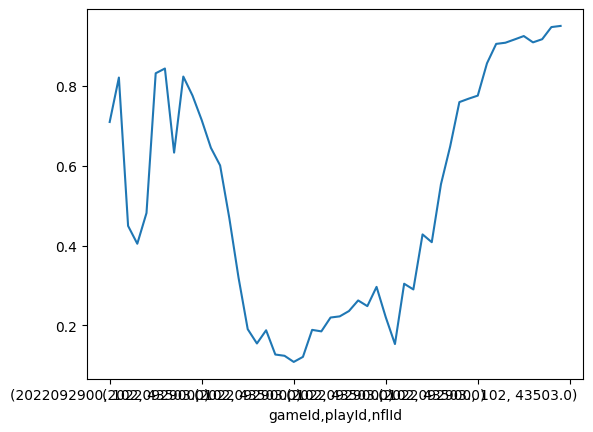

In [380]:
defense.set_index(["gameId", "playId","nflId"]).loc[(2022092900, 102, 43503)]["tackling_probability"].plot()

In [327]:
def get_missed_tackle_features(group):
    group = group.sort_values("frameId")
    argmax = group["tackling_probability"].argmax()
    res = group[["tackling_probability", "distance_to_ball_carrier", "ball_carrier_distance_to_endzone","frameId"]].iloc[argmax]
    res["frame_progression"] = (res["frameId"] - group["frameId"].min()) / (group["frameId"].max() - group["frameId"].min())
    res["nb_frames_from_end"] = group["frameId"].max() - res["frameId"]
    res = res.drop(index="frameId")
    res["last_distance_to_ball_carrier"] = group.iloc[-1]["distance_to_ball_carrier"]
    res["last_tackling_probability"] = group.iloc[-1]["tackling_probability"]
    res["ball_carrier_distance_won_to_last_frame"] = max(res["ball_carrier_distance_to_endzone"] - group.iloc[-1]["ball_carrier_distance_to_endzone"], 0)
    res = res.drop(index="ball_carrier_distance_to_endzone")
    return res
    

features_missed = defense.groupby(["gameId", "playId","nflId"]).apply(get_missed_tackle_features)

In [330]:
targeted_features_missed = features_missed.merge(
    tackles[tackles["pff_missedTackle"]==1].set_index(["gameId", "playId","nflId"])[["pff_missedTackle"]],
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

In [331]:
tackles_2 = tackles.copy()

tackles_2["tackle_or_assist"] = tackles_2[["tackle", "assist"]].max(axis=1)
tackles_2 = tackles_2[(tackles_2["tackle_or_assist"] == 1)].set_index(["gameId", "playId","nflId"])[["tackle_or_assist"]]
targeted_features_missed = targeted_features_missed.merge(
    tackles_2,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

In [371]:
targeted_features_missed.shape

(127941, 9)

In [344]:
targeted_features_missed.to_csv("../data/features_mott.csv")

In [332]:
sample_targeted_features_missed = pd.concat([
    targeted_features_missed[targeted_features_missed["pff_missedTackle"]==1],
    targeted_features_missed[targeted_features_missed["pff_missedTackle"]==0].sample(
        len(targeted_features_missed[targeted_features_missed["pff_missedTackle"]==1])*10
    )
])

In [333]:
sample_targeted_features_missed

tackling_probability  distance_to_ball_carrier  \
gameId     playId nflId                                                     
2022090800 1102   52492.0              0.928455                  0.413401   
           1385   40107.0              0.761828                  0.778781   
                  46232.0              0.866063                  2.188378   
           2163   43335.0              0.936913                  0.431045   
           2208   42816.0              0.927987                  0.843090   
...                                         ...                       ...   
2022101601 2344   43522.0              0.908742                  0.560892   
2022101602 888    53629.0              0.000448                 24.698528   
2022110602 678    54948.0              0.910245                  0.193132   
2022091110 2765   53639.0              0.098633                  6.006638   
2022091801 1433   54533.0              0.143505                 16.508483   

                           frame_progression  nb_frames_from_end  \
gameId     playId nflId                                            
2022090800 1102   52492.0           0.250000                33.0   
           1385   40107.0           0.757576                16.0   
                  46232.0           0.454545                36.0   
           2163   43335.0           0.596774                25.0   
           2208   42816.0           0.268293                30.0   
...                                      ...                 ...   
2022101601 2344   43522.0           0.758621                14.0   
2022101602 888    53629.0           0.375000                 5.0   
2022110602 678    54948.0           0.975610                 1.0   
2022091110 2765   53639.0           0.403226                37.0   
2022091801 1433   54533.0           0.254545                41.0   

                           last_distance_to_ball_carrier  \
gameId     playId nflId                                    
2022090800 1102   52492.0                       3.117082   
           1385   40107.0                       1.422849   
                  46232.0                      12.631853   
           2163   43335.0                       3.633208   
           2208   42816.0                       9.724865   
...                                                  ...   
2022101601 2344   43522.0                       1.786197   
2022101602 888    53629.0                      24.861094   
2022110602 678    54948.0                       0.246982   
2022091110 2765   53639.0                       4.895794   
2022091801 1433   54533.0                      10.403999   

                           last_tackling_probability  \
gameId     playId nflId                                
2022090800 1102   52492.0                   0.011906   
           1385   40107.0                   0.640471   
                  46232.0                   0.000505   
           2163   43335.0                   0.032897   
           2208   42816.0                   0.001142   
...                                              ...   
2022101601 2344   43522.0                   0.063105   
2022101602 888    53629.0                   0.000414   
2022110602 678    54948.0                   0.856775   
2022091110 2765   53639.0                   0.032724   
2022091801 1433   54533.0                   0.018159   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022090800 1102   52492.0                                     0.23   
           1385   40107.0                                     5.28   
                  46232.0                                    19.48   
           2163   43335.0                                     7.26   
           2208   42816.0                                     9.25   
...                                                            ...   
2022101601 2344   43522.0                                     0.00   


In [334]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_targeted_features_missed.drop(columns=["pff_missedTackle"]), 
    sample_targeted_features_missed["pff_missedTackle"], 
    test_size=0.33, 
    random_state=42
)

In [353]:
model = CatBoostClassifier(max_depth=2, scale_pos_weight=5, verbose=0)
model.fit(X_train, y_train)

In [354]:
y_pred = model.predict(X_test)

In [355]:
y_test.sum()/len(y_test)

0.08632490571308842

In [356]:
y_pred.sum()/len(y_pred)

0.10783628998463472

In [357]:
balanced_accuracy_score(y_train, model.predict(X_train))

0.9310693638541151

In [358]:
balanced_accuracy_score(y_test, y_pred)

0.9165024052911953

In [359]:
confusion_matrix(y_train, model.predict(X_train))

array([[12754,   425],
       [  143,  1211]], dtype=int64)

In [360]:
confusion_matrix(y_test, y_pred)

array([[6306,  235],
       [  81,  537]], dtype=int64)

In [370]:
import pickle
pickle.dump(model, open("../models/model_mott.pkl", 'wb'))

In [361]:
unsample_targeted_features_missed = targeted_features_missed[~targeted_features_missed.index.isin(sample_targeted_features_missed.index)].copy()

In [362]:
model.predict(unsample_targeted_features_missed.drop(columns=["pff_missedTackle"])).sum()/len(unsample_targeted_features_missed)

0.035143860177507556

In [363]:
unsample_targeted_features_missed["prediction"] = model.predict(unsample_targeted_features_missed.drop(columns=["pff_missedTackle"]))

In [364]:
unsample_targeted_features_missed[unsample_targeted_features_missed["prediction"]==1]

tackling_probability  distance_to_ball_carrier  \
gameId     playId nflId                                                     
2022090800 80     47917.0              0.711906                  2.248777   
           393    37075.0              0.660447                  3.352760   
                  42395.0              0.750396                  0.674240   
           692    47862.0              0.890012                  4.793537   
                  48026.0              0.953389                 10.886836   
...                                         ...                       ...   
2022110700 3658   48537.0              0.501459                  1.400321   
                  48544.0              0.791755                  0.455412   
           3686   48027.0              0.950741                  0.284429   
                  52482.0              0.875101                  0.351141   
           3707   52482.0              0.915491                  0.801124   

                           frame_progression  nb_frames_from_end  \
gameId     playId nflId                                            
2022090800 80     47917.0           0.240000                19.0   
           393    37075.0           0.304348                32.0   
                  42395.0           0.652174                16.0   
           692    47862.0           0.032258                30.0   
                  48026.0           0.032258                30.0   
...                                      ...                 ...   
2022110700 3658   48537.0           0.530612                23.0   
                  48544.0           0.612245                19.0   
           3686   48027.0           0.424242                38.0   
                  52482.0           0.621212                25.0   
           3707   52482.0           0.729167                13.0   

                           last_distance_to_ball_carrier  \
gameId     playId nflId                                    
2022090800 80     47917.0                       1.994492   
           393    37075.0                       3.567072   
                  42395.0                       3.116168   
           692    47862.0                       2.662480   
                  48026.0                       2.888200   
...                                                  ...   
2022110700 3658   48537.0                       6.779860   
                  48544.0                       6.754036   
           3686   48027.0                       1.015135   
                  52482.0                       4.027170   
           3707   52482.0                       1.753454   

                           last_tackling_probability  \
gameId     playId nflId                                
2022090800 80     47917.0                   0.277580   
           393    37075.0                   0.015195   
                  42395.0                   0.059716   
           692    47862.0                   0.106605   
                  48026.0                   0.049855   
...                                              ...   
2022110700 3658   48537.0                   0.001283   
                  48544.0                   0.003068   
           3686   48027.0                   0.178593   
                  52482.0                   0.012183   
           3707   52482.0                   0.550580   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022090800 80     47917.0                                     8.34   
           393    37075.0                                     5.70   
                  42395.0                                     0.82   
           692    47862.0                                     1.56   
                  48026.0                                     1.56   
...                                                            ...   
2022110700 3658   48537.0                                     6.30   


In [365]:
result_data = targeted_features_missed.copy()
result_data["prediction"] = model.predict(result_data.drop(columns=["pff_missedTackle"]))

In [366]:
result_data[(result_data["pff_missedTackle"]==1) & (result_data["prediction"]==0)]

tackling_probability  distance_to_ball_carrier  \
gameId     playId nflId                                                     
2022091100 2135   46091.0              0.927017                  0.170294   
                  52424.0              0.906007                  0.502195   
2022091101 1213   46124.0              0.556870                  4.032716   
           2001   46527.0              0.536516                  3.547013   
2022091102 189    52571.0              0.962559                  0.304138   
...                                         ...                       ...   
2022110608 1382   43986.0              0.856968                  0.872812   
           2517   49410.0              0.691596                  0.967988   
2022110609 445    43335.0              0.923481                  0.528015   
2022110610 423    52469.0              0.657302                  1.189622   
           2629   46846.0              0.901217                  0.639062   

                           frame_progression  nb_frames_from_end  \
gameId     playId nflId                                            
2022091100 2135   46091.0           0.692308                 8.0   
                  52424.0           0.346154                17.0   
2022091101 1213   46124.0           0.461538                28.0   
           2001   46527.0           0.461538                28.0   
2022091102 189    52571.0           0.906977                 4.0   
...                                      ...                 ...   
2022110608 1382   43986.0           0.818182                 8.0   
           2517   49410.0           0.846154                 6.0   
2022110609 445    43335.0           0.978261                 1.0   
2022110610 423    52469.0           0.700000                18.0   
           2629   46846.0           0.785714                 6.0   

                           last_distance_to_ball_carrier  \
gameId     playId nflId                                    
2022091100 2135   46091.0                       3.968337   
                  52424.0                       1.141271   
2022091101 1213   46124.0                       2.086912   
           2001   46527.0                      15.870176   
2022091102 189    52571.0                       1.917837   
...                                                  ...   
2022110608 1382   43986.0                       0.781089   
           2517   49410.0                       2.122852   
2022110609 445    43335.0                       0.608769   
2022110610 423    52469.0                       1.758010   
           2629   46846.0                       3.062058   

                           last_tackling_probability  \
gameId     playId nflId                                
2022091100 2135   46091.0                   0.314927   
                  52424.0                   0.752735   
2022091101 1213   46124.0                   0.116213   
           2001   46527.0                   0.000090   
2022091102 189    52571.0                   0.448217   
...                                              ...   
2022110608 1382   43986.0                   0.594666   
           2517   49410.0                   0.059141   
2022110609 445    43335.0                   0.873860   
2022110610 423    52469.0                   0.368516   
           2629   46846.0                   0.504722   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022091100 2135   46091.0                                     2.62   
                  52424.0                                     2.78   
2022091101 1213   46124.0                                     8.83   
           2001   46527.0                                    11.42   
2022091102 189    52571.0                                     2.01   
...                                                            ...   
2022110608 1382   43986.0                                     1.84   


In [367]:
result_data[(result_data["pff_missedTackle"]==0) & (result_data["prediction"]==1)]

tackling_probability  distance_to_ball_carrier  \
gameId     playId nflId                                                     
2022090800 80     47917.0              0.711906                  2.248777   
           393    37075.0              0.660447                  3.352760   
                  42395.0              0.750396                  0.674240   
           692    47862.0              0.890012                  4.793537   
                  48026.0              0.953389                 10.886836   
...                                         ...                       ...   
2022110700 3658   48537.0              0.501459                  1.400321   
                  48544.0              0.791755                  0.455412   
           3686   48027.0              0.950741                  0.284429   
                  52482.0              0.875101                  0.351141   
           3707   52482.0              0.915491                  0.801124   

                           frame_progression  nb_frames_from_end  \
gameId     playId nflId                                            
2022090800 80     47917.0           0.240000                19.0   
           393    37075.0           0.304348                32.0   
                  42395.0           0.652174                16.0   
           692    47862.0           0.032258                30.0   
                  48026.0           0.032258                30.0   
...                                      ...                 ...   
2022110700 3658   48537.0           0.530612                23.0   
                  48544.0           0.612245                19.0   
           3686   48027.0           0.424242                38.0   
                  52482.0           0.621212                25.0   
           3707   52482.0           0.729167                13.0   

                           last_distance_to_ball_carrier  \
gameId     playId nflId                                    
2022090800 80     47917.0                       1.994492   
           393    37075.0                       3.567072   
                  42395.0                       3.116168   
           692    47862.0                       2.662480   
                  48026.0                       2.888200   
...                                                  ...   
2022110700 3658   48537.0                       6.779860   
                  48544.0                       6.754036   
           3686   48027.0                       1.015135   
                  52482.0                       4.027170   
           3707   52482.0                       1.753454   

                           last_tackling_probability  \
gameId     playId nflId                                
2022090800 80     47917.0                   0.277580   
           393    37075.0                   0.015195   
                  42395.0                   0.059716   
           692    47862.0                   0.106605   
                  48026.0                   0.049855   
...                                              ...   
2022110700 3658   48537.0                   0.001283   
                  48544.0                   0.003068   
           3686   48027.0                   0.178593   
                  52482.0                   0.012183   
           3707   52482.0                   0.550580   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022090800 80     47917.0                                     8.34   
           393    37075.0                                     5.70   
                  42395.0                                     0.82   
           692    47862.0                                     1.56   
                  48026.0                                     1.56   
...                                                            ...   
2022110700 3658   48537.0                                     6.30   


In [368]:
result_data[(result_data["pff_missedTackle"]==1)].shape

(1972, 10)

In [369]:
result_data[(result_data["prediction"]==1)].shape

(6142, 10)

In [372]:
result_data.loc[(2022100911,2915)]

,tackling_probability,distance_to_ball_carrier,frame_progression,nb_frames_from_end,last_distance_to_ball_carrier,last_tackling_probability,ball_carrier_distance_won_to_last_frame,pff_missedTackle,tackle_or_assist,prediction
nflId,,,,,,,,,,
42401.0,0.006873,16.340973,0.225806,24.0,21.376606,0.000328,7.07,0.0,0.0,0.0
43986.0,0.882433,2.529763,0.225806,24.0,8.393736,0.004496,7.07,1.0,0.0,1.0
44848.0,0.174233,9.309307,0.903226,3.0,7.450000,0.103994,1.66,0.0,0.0,0.0
47816.0,0.907272,0.843090,0.612903,12.0,6.764148,0.110931,5.02,0.0,1.0,1.0
47848.0,0.015879,11.987464,0.161290,26.0,21.819086,0.000254,7.43,0.0,0.0,0.0
49410.0,0.143826,11.624973,0.806452,6.0,8.035173,0.092732,3.07,0.0,0.0,0.0
52416.0,0.721639,1.190966,0.774194,7.0,3.745931,0.465870,3.48,0.0,0.0,1.0
52522.0,0.030390,8.834501,0.161290,26.0,10.554336,0.003828,7.43,0.0,0.0,0.0
53445.0,0.180480,5.606291,1.000000,0.0,5.606291,0.180480,0.00,0.0,0.0,0.0


In [9]:
sequences_data = defense.sort_values(
    ["gameId", "playId","nflId","frameId"]
).groupby(["gameId", "playId","nflId"]).agg({"tackling_probability": list, "distance_to_ball_carrier": list})

In [10]:
sequences_data["features"] = sequences_data.apply(lambda x: list(zip(x["tackling_probability"], x["distance_to_ball_carrier"])), axis=1)

In [11]:
sequences_data

tackling_probability  \
gameId     playId nflId                                                        
2022090800 56     38577.0  [0.4799024376209959, 0.6139865108728217, 0.648...   
                  41239.0  [0.0023822038346252, 0.0022249843093679, 0.004...   
                  42816.0  [0.0127909791825101, 0.0199881797926921, 0.025...   
                  43294.0  [0.6917663989221121, 0.8164756988909171, 0.827...   
                  43298.0  [0.0037908290988515, 0.0029641368382249, 0.002...   
...                                                                      ...   
2022110700 3787   52627.0  [0.0246112080733568, 0.0264049779590205, 0.038...   
                  53460.0  [0.0158649398278804, 0.0341196519900312, 0.032...   
                  53533.0  [0.0074885259613863, 0.0098887300359901, 0.010...   
                  54541.0  [0.0349480059150449, 0.0220976443080483, 0.027...   
                  54606.0  [0.0245073085558064, 0.027064298381491, 0.0419...   

                                                    distance_to_ball_carrier  \
gameId     playId nflId                                                        
2022090800 56     38577.0  [10.246877573192725, 9.46448625124471, 8.64653...   
                  41239.0  [12.602539426639376, 12.828503420118812, 13.04...   
                  42816.0  [31.146508632589946, 30.705056586822963, 30.26...   
                  43294.0  [3.528809997718784, 3.4132096331752027, 3.2585...   
                  43298.0  [12.298995893974428, 12.337787483985938, 12.38...   
...                                                                      ...   
2022110700 3787   52627.0  [22.327113561766108, 22.364918958046776, 22.40...   
                  53460.0  [6.988275896099123, 6.952416845960834, 6.88971...   
                  53533.0  [27.6007427436292, 27.62884362401004, 27.63506...   
                  54541.0  [5.715706430529825, 5.684091835992801, 5.65517...   
                  54606.0  [19.658618974892416, 19.669763597969347, 19.68...   

                                                                    features  
gameId     playId nflId                                                       
2022090800 56     38577.0  [(0.4799024376209959, 10.246877573192725), (0....  
                  41239.0  [(0.0023822038346252, 12.602539426639376), (0....  
                  42816.0  [(0.0127909791825101, 31.146508632589946), (0....  
                  43294.0  [(0.6917663989221121, 3.528809997718784), (0.8...  
                  43298.0  [(0.0037908290988515, 12.298995893974428), (0....  
...                                                                      ...  
2022110700 3787   52627.0  [(0.0246112080733568, 22.327113561766108), (0....  
                  53460.0  [(0.0158649398278804, 6.988275896099123), (0.0...  
                  53533.0  [(0.0074885259613863, 27.6007427436292), (0.00...  
                  54541.0  [(0.0349480059150449, 5.715706430529825), (0.0...  
                  54606.0  [(0.0245073085558064, 19.658618974892416), (0....  

[127941 rows x 3 columns]

In [12]:
tackles["pff_missedTackle"].value_counts()

pff_missedTackle
0    15336
1     2090
Name: count, dtype: int64

In [13]:
sequences_data = sequences_data.merge(
    tackles[tackles["pff_missedTackle"]==1].set_index(["gameId", "playId","nflId"])[["pff_missedTackle"]],
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

In [14]:
sequences_data["pff_missedTackle"].value_counts()

pff_missedTackle
0.0    125969
1.0      1972
Name: count, dtype: int64

In [15]:
sequences_data

tackling_probability  \
gameId     playId nflId                                                        
2022090800 56     38577.0  [0.4799024376209959, 0.6139865108728217, 0.648...   
                  41239.0  [0.0023822038346252, 0.0022249843093679, 0.004...   
                  42816.0  [0.0127909791825101, 0.0199881797926921, 0.025...   
                  43294.0  [0.6917663989221121, 0.8164756988909171, 0.827...   
                  43298.0  [0.0037908290988515, 0.0029641368382249, 0.002...   
...                                                                      ...   
2022110700 3787   52627.0  [0.0246112080733568, 0.0264049779590205, 0.038...   
                  53460.0  [0.0158649398278804, 0.0341196519900312, 0.032...   
                  53533.0  [0.0074885259613863, 0.0098887300359901, 0.010...   
                  54541.0  [0.0349480059150449, 0.0220976443080483, 0.027...   
                  54606.0  [0.0245073085558064, 0.027064298381491, 0.0419...   

                                                    distance_to_ball_carrier  \
gameId     playId nflId                                                        
2022090800 56     38577.0  [10.246877573192725, 9.46448625124471, 8.64653...   
                  41239.0  [12.602539426639376, 12.828503420118812, 13.04...   
                  42816.0  [31.146508632589946, 30.705056586822963, 30.26...   
                  43294.0  [3.528809997718784, 3.4132096331752027, 3.2585...   
                  43298.0  [12.298995893974428, 12.337787483985938, 12.38...   
...                                                                      ...   
2022110700 3787   52627.0  [22.327113561766108, 22.364918958046776, 22.40...   
                  53460.0  [6.988275896099123, 6.952416845960834, 6.88971...   
                  53533.0  [27.6007427436292, 27.62884362401004, 27.63506...   
                  54541.0  [5.715706430529825, 5.684091835992801, 5.65517...   
                  54606.0  [19.658618974892416, 19.669763597969347, 19.68...   

                                                                    features  \
gameId     playId nflId                                                        
2022090800 56     38577.0  [(0.4799024376209959, 10.246877573192725), (0....   
                  41239.0  [(0.0023822038346252, 12.602539426639376), (0....   
                  42816.0  [(0.0127909791825101, 31.146508632589946), (0....   
                  43294.0  [(0.6917663989221121, 3.528809997718784), (0.8...   
                  43298.0  [(0.0037908290988515, 12.298995893974428), (0....   
...                                                                      ...   
2022110700 3787   52627.0  [(0.0246112080733568, 22.327113561766108), (0....   
                  53460.0  [(0.0158649398278804, 6.988275896099123), (0.0...   
                  53533.0  [(0.0074885259613863, 27.6007427436292), (0.00...   
                  54541.0  [(0.0349480059150449, 5.715706430529825), (0.0...   
                  54606.0  [(0.0245073085558064, 19.658618974892416), (0....   

                           pff_missedTackle  
gameId     playId nflId                      
2022090800 56     38577.0               0.0  
                  41239.0               0.0  
                  42816.0               0.0  
                  43294.0               0.0  
                  43298.0               0.0  
...                                     ...  
2022110700 3787   52627.0               0.0  
                  53460.0               0.0  
                  53533.0               0.0  
                  54541.0               0.0  
                  54606.0               0.0  

[127941 rows x 4 columns]

In [16]:
sequences = sequences_data["features"]

In [17]:
sequences

gameId      playId  nflId  
2022090800  56      38577.0    [(0.4799024376209959, 10.246877573192725), (0....
                    41239.0    [(0.0023822038346252, 12.602539426639376), (0....
                    42816.0    [(0.0127909791825101, 31.146508632589946), (0....
                    43294.0    [(0.6917663989221121, 3.528809997718784), (0.8...
                    43298.0    [(0.0037908290988515, 12.298995893974428), (0....
                                                     ...                        
2022110700  3787    52627.0    [(0.0246112080733568, 22.327113561766108), (0....
                    53460.0    [(0.0158649398278804, 6.988275896099123), (0.0...
                    53533.0    [(0.0074885259613863, 27.6007427436292), (0.00...
                    54541.0    [(0.0349480059150449, 5.715706430529825), (0.0...
                    54606.0    [(0.0245073085558064, 19.658618974892416), (0....
Name: features, Length: 127941, dtype: object

In [18]:
max_seq_length = max(len(seq) for seq in sequences)

In [19]:
max_seq_length

155

In [20]:
padded_sequences = np.full((len(sequences), max_seq_length, 2), -1.)
for i, seq in enumerate(sequences):
    padded_sequences[i, -len(seq):] = seq

In [21]:
padded_sequences_data = pd.Series(padded_sequences.tolist(), index=sequences_data.index)

In [22]:
padded_sequences_data

gameId      playId  nflId  
2022090800  56      38577.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    41239.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    42816.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    43294.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    43298.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                                                     ...                        
2022110700  3787    52627.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    53460.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    53533.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    54541.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
                    54606.0    [[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...
Length: 127941, dtype: object

In [23]:
y  = sequences_data["pff_missedTackle"]#.astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_data, y, test_size=0.33, random_state=42)

In [25]:
input_shape = (max_seq_length, 2)  # Forme d'entrée
model_input = Input(shape=input_shape)
x = Masking(mask_value=-1.)(model_input)  # Couche de masquage pour gérer les longueurs variables
x = Bidirectional(LSTM(32))(x)
output = Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=model_input, outputs=output)

In [26]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [27]:
import tensorflow as tf

focal_loss = tf.keras.losses.BinaryFocalCrossentropy()

In [28]:
model.compile(optimizer='adam', loss=focal_loss, metrics=["accuracy", METRICS])

In [29]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_precision", patience=3, restore_best_weights=True)

In [30]:
class_weights = {0: 0.05, 1: 0.95}

In [31]:
model.fit(np.stack(X_train), y_train, epochs=10, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
2143/2143 [==============================] - 198s 89ms/step - loss: 0.0044 - accuracy: 0.9442 - tp: 775.0000 - fp: 3533.0000 - tn: 63973.0000 - fn: 295.0000 - precision: 0.1799 - recall: 0.7243 - auc: 0.9368 - prc: 0.3272 - val_loss: 0.0251 - val_accuracy: 0.9626 - val_tp: 239.0000 - val_fp: 609.0000 - val_tn: 16264.0000 - val_fn: 32.0000 - val_precision: 0.2818 - val_recall: 0.8819 - val_auc: 0.9651 - val_prc: 0.5919
Epoch 2/10
2143/2143 [==============================] - 175s 82ms/step - loss: 0.0027 - accuracy: 0.9624 - tp: 944.0000 - fp: 2454.0000 - tn: 65052.0000 - fn: 126.0000 - precision: 0.2778 - recall: 0.8822 - auc: 0.9744 - prc: 0.5606 - val_loss: 0.0328 - val_accuracy: 0.9414 - val_tp: 249.0000 - val_fp: 983.0000 - val_tn: 15890.0000 - val_fn: 22.0000 - val_precision: 0.2021 - val_recall: 0.9188 - val_auc: 0.9641 - val_prc: 0.6127
Epoch 3/10
2143/2143 [==============================] - 192s 90ms/step - loss: 0.0025 - accuracy: 0.9661 - tp: 964.0000 - fp: 2218.000

In [32]:
model.evaluate(np.stack(X_test), y_test)

1320/1320 [==============================] - 36s 27ms/step - loss: 0.0337 - accuracy: 0.9379 - tp: 587.0000 - fp: 2576.0000 - tn: 39014.0000 - fn: 44.0000 - precision: 0.1856 - recall: 0.9303 - auc: 0.9737 - prc: 0.5676


[0.0337420329451561,
 0.937945544719696,
 587.0,
 2576.0,
 39014.0,
 44.0,
 0.18558330833911896,
 0.9302694201469421,
 0.9736918807029724,
 0.5676096081733704]

In [33]:
y_pred = model.predict(np.stack(X_test))

1320/1320 [==============================] - 39s 28ms/step


In [34]:
y_pred_data = pd.DataFrame(y_pred, columns=["missed_tackle_prediction"], index=X_test.index)["missed_tackle_prediction"]

In [36]:
y_pred_data[y_pred_data>0.5]

gameId      playId  nflId  
2022110300  2479    46199.0    0.521098
2022100903  928     43787.0    0.645732
2022100600  3489    45287.0    0.680094
2022102308  1444    54540.0    0.789743
2022100902  1970    41231.0    0.516186
                                 ...   
2022100913  267     43350.0    0.735428
2022103000  3261    40347.0    0.712628
2022101604  3884    46652.0    0.543850
2022091200  1764    44873.0    0.581860
2022110700  2902    38607.0    0.673457
Name: missed_tackle_prediction, Length: 3163, dtype: float32

In [43]:
tackles.set_index(["gameId", "playId","nflId"]).loc[(2022100600, 3489)]

C:\Users\mleca\AppData\Local\Temp\ipykernel_10364\1242244781.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tackles.set_index(["gameId", "playId","nflId"]).loc[(2022100600, 3489)]


,tackle,assist,forcedFumble,pff_missedTackle
nflId,,,,
45287,1,0,0,0


In [37]:
y_test[y_test==1]

gameId      playId  nflId  
2022100903  928     43787.0    1.0
2022102308  1444    54540.0    1.0
2022103000  2792    42929.0    1.0
2022100212  2007    43411.0    1.0
2022102400  2866    43522.0    1.0
                              ... 
2022091801  1433    44813.0    1.0
2022101602  2837    47881.0    1.0
2022102309  491     46775.0    1.0
2022110610  544     46144.0    1.0
2022103011  2078    42543.0    1.0
Name: pff_missedTackle, Length: 631, dtype: float64

In [ ]:
y_pred_data[y_pred_data>0.5].head(10)

gameId      playId  nflId  
2022092900  3704    46146.0    0.570932
2022091806  3511    44886.0    0.541860
2022092200  419     52452.0    0.550901
2022100906  3654    46711.0    0.671759
2022100900  1183    47800.0    0.721699
2022110300  2479    46199.0    0.686776
2022100903  928     43787.0    0.835467
2022091100  3647    46135.0    0.778647
2022100600  3489    45287.0    0.782705
2022102311  2364    53447.0    0.516981
Name: missed_tackle_prediction, dtype: float32

In [ ]:
y_pred_data.loc[(2022110606, 913)]

C:\Users\mleca\AppData\Local\Temp\ipykernel_22344\75686180.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  y_pred_data.loc[(2022110606, 913)]


nflId
47881.0    0.701191
54491.0    0.048060
42467.0    0.183540
41270.0    0.280995
46211.0    0.214126
41243.0    0.708883
Name: missed_tackle_prediction, dtype: float32

In [ ]:
tackles.set_index(["gameId", "playId","nflId"]).loc[(2022110606 ,913)]

C:\Users\mleca\AppData\Local\Temp\ipykernel_22344\269796278.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tackles.set_index(["gameId", "playId","nflId"]).loc[(2022110606 ,913)]


,tackle,assist,forcedFumble,pff_missedTackle
nflId,,,,
42467,0,1,0,0
46211,0,1,0,0
41243,0,0,0,1


In [375]:
games = pd.read_csv("../data/games.csv")
plays = pd.read_csv("../data/plays.csv")

In [376]:
games.set_index(["gameId"]).loc[2022100911]

season                     2022
week                          5
gameDate             10/09/2022
gameTimeEastern        16:25:00
homeTeamAbbr                ARI
visitorTeamAbbr             PHI
homeFinalScore               17
visitorFinalScore            20
Name: 2022100911, dtype: object

In [377]:
plays.set_index(["gameId", "playId"]).loc[(2022100911,2915)]

ballCarrierId                                                                   53439
ballCarrierDisplayName                                                  DeVonta Smith
playDescription                     (2:52) (No Huddle, Shotgun) J.Hurts pass short...
quarter                                                                             3
down                                                                                2
yardsToGo                                                                           4
possessionTeam                                                                    PHI
defensiveTeam                                                                     ARI
yardlineSide                                                                      ARI
yardlineNumber                                                                     47
gameClock                                                                        2:52
preSnapHomeScore                                      

In [ ]:
y_pred_data[(y_test==1)&(y_pred_data>0.5)]

gameId      playId  nflId  
2022100903  928     43787.0    0.400973
2022102308  1444    54540.0    0.316593
2022103000  2792    42929.0    0.158364
2022100212  2007    43411.0    0.265564
2022102400  2866    43522.0    0.186679
                                 ...   
2022091801  1433    44813.0    0.388391
2022101602  2837    47881.0    0.317107
2022102309  491     46775.0    0.408102
2022110610  544     46144.0    0.345641
2022103011  2078    42543.0    0.165909
Name: missed_tackle_prediction, Length: 514, dtype: float32

In [ ]:
y_pred_data[(y_test==1)&(y_pred_data<=0.5)]

gameId      playId  nflId  
2022091803  1412    43358.0    0.055713
2022091104  462     54467.0    0.083907
2022102304  1538    55032.0    0.065224
2022091106  998     43700.0    0.086052
2022110608  2327    42543.0    0.049697
                                 ...   
2022091111  1790    53476.0    0.096268
2022102303  1153    47996.0    0.046931
2022110601  1791    45009.0    0.063858
2022091107  868     54479.0    0.080622
2022091106  1895    47934.0    0.074364
Name: missed_tackle_prediction, Length: 117, dtype: float32